In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ML-Climate-Predicting-Wildfires/src')

In [ ]:
!pip install keras-tuner -q
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D,\
                         TimeDistributed, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

import keras_tuner as kt
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
import seaborn as sns

In [ ]:
class Batch_Loader(tf.keras.utils.Sequence) :
  
  def __init__(self, dataset_name) :
    self.dataset_name = dataset_name
    num_batches = len([x for x in os.listdir(f'data/TrainingData/{self.dataset_name}') if '_X.npy' in x])
    self.num_batches = num_batches
    
  def __len__(self) :
    return self.num_batches

  def __getitem__(self, idx) :
    X = np.load(f'data/TrainingData/{self.dataset_name}/{idx}_X.npy')
    y = np.load(f'data/TrainingData/{self.dataset_name}/{idx}_y.npy')
    return X, y

In [ ]:
train_generator = Batch_Loader('train')
val_generator = Batch_Loader('val')
test_generator = Batch_Loader('test')

In [ ]:
from keras import layers

NBFRAME = 6
INPUT_WIDTH = 128
INPUT_HEIGHT = 128
N_CHANNELS = 12

# Reference: https://keras.io/examples/vision/video_transformers/

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

def get_convnet(shape, hp):
    n_conv = hp.Int("n_conv", 1, 3, step=1)
    dim_conv = hp.Choice("dim_fc", values=[32,64,128])
    droupout_rate = hp.Float("dropout", 0, 0.3, step=0.1)
    bn_momentum = hp.Float("bn_momentum", 0.9, 0.99, step=0.03)
    embed_dim = hp.Choice("dim_embed", values=[128,256,512])
    n_fc = hp.Int("n_fc", 1, 3, step=1)

    convnet = keras.Sequential()
    for i_conv in range(n_conv):
      convnet.add(Conv2D(dim_conv*2**i_conv, (3,3), input_shape=shape[1:],
          padding='same', activation='relu'))
      convnet.add(Conv2D(dim_conv*2**i_conv, (3,3), padding='same', activation='relu'))
      convnet.add(BatchNormalization(momentum=bn_momentum))
      convnet.add(MaxPool2D(input_shape=convnet.layers[-1].output_shape))
    convnet.add(Conv2D(dim_conv*2**n_conv, (3,3), padding='same', activation='relu'))
    convnet.add(Conv2D(dim_conv*2**n_conv, (3,3), padding='same', activation='relu'))
    convnet.add(BatchNormalization(momentum=bn_momentum))
    convnet.add(GlobalMaxPool2D(input_shape=convnet.layers[-1].output_shape))

    for i_fc in range(n_fc):
      convnet.add(Dense(embed_dim, activation='relu'))
      convnet.add(Dropout(droupout_rate))
    return convnet

def get_compiled_model(hp):
    shape=(NBFRAME,) + (INPUT_WIDTH, INPUT_HEIGHT) + (N_CHANNELS,) # (6, 128, 128, 12)

    dim_fc = hp.Choice("dim_fc", values=[128,256,512])
    lr = hp.Float("lr", 1e-5, 1e-4, step=1e-5)
    eps = hp.Float("eps", 1e-8, 5e-8, step=1e-8)
    droupout_rate = hp.Float("dropout", 0, 0.3, step=0.1)
    layer_norm_eps = hp.Float("layer_norm_eps", 1e-6, 1e-5, step=1e-6)
    embed_dim = hp.Choice("dim_embed", values=[128,256,512])
    num_heads = hp.Int("n_heads", 2, 6, step=1)

    inputs = keras.Input(shape=shape)
    # Inputs images --> embeddings
    convnet = get_convnet(shape, hp)

    x = TimeDistributed(convnet,input_shape=shape)(inputs)
    x = PositionalEmbedding(
        NBFRAME, embed_dim, name="frame_position_embedding"
    )(x)
    x = TransformerEncoder(embed_dim, dim_fc, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr,
                                      epsilon=eps)
    model.compile(
        optimizer,
        'binary_crossentropy',
        metrics=['accuracy', Precision(), Recall(), AUC()])
    return model


#### Tuning hyperparameters

In [ ]:
# Instantiate the tuner
tuner = kt.RandomSearch(get_compiled_model,
                     objective=kt.Objective("val_auc", direction="max"),
                     max_trials=10,
                     executions_per_trial=1,
                     overwrite=False,
                     directory="models/Transformer_2/",
                     project_name="HP_Tuning")

INFO:tensorflow:Reloading Oracle from existing project models/Transformer_2/HP_Tuning/oracle.json
INFO:tensorflow:Reloading Tuner from models/Transformer_2/HP_Tuning/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 12
n_fc (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
dim_fc (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
dim_fc_collapse (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.0001, 'step': 1e-05, 'sampling': None}
eps (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 5e-08, 'step': 1e-08, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
layer_norm_eps (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 1e-05, 'step': 1e-06, 'sampling': None}
dim_embed (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
n_heads (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sam

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                 patience=4, min_lr=5e-06)

tuner.search(train_generator, 
             steps_per_epoch = len(train_generator),
             epochs = 50,
             verbose = 1,
             validation_data = val_generator,
             validation_steps = len(val_generator),
             callbacks=[reduce_lr, stop_early])

Trial 10 Complete [00h 12m 47s]
val_auc: 0.8538172245025635

Best val_auc So Far: 0.8601686358451843
Total elapsed time: 03h 01m 08s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'bn_momentum': 0.9900000000000001,
 'dim_embed': 128,
 'dim_fc': 128,
 'dim_fc_collapse': False,
 'dropout': 0.30000000000000004,
 'eps': 4e-08,
 'layer_norm_eps': 5.999999999999999e-06,
 'lr': 3.0000000000000004e-05,
 'n_conv': 3,
 'n_fc': 1,
 'n_heads': 4,
 'n_layers': 2}

#### Train with best hyperparams

In [ ]:
# Build model
model = tuner.hypermodel.build(best_hps)

In [ ]:
experiment_name = "Final"
log_dir = f"models/Transformer_2/{experiment_name}"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = f"{log_dir}/ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                                 patience=5, min_lr=5e-06)

In [ ]:
history = model.fit(train_generator, 
             steps_per_epoch = len(train_generator),
             epochs = 50,
             verbose = 1,
             validation_data = val_generator,
             validation_steps = len(val_generator),
	 					 callbacks=[tensorboard_callback, 
	                      model_checkpoint_callback,
                        reduce_lr])

Layer PositionalEmbedding has arguments ['self', 'sequence_length', 'output_dim']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


104/104 [==============================] - 205s 2s/step - loss: 0.7665 - accuracy: 0.6370 - precision_1: 0.6412 - recall_1: 0.6608 - auc_1: 0.6859 - val_loss: 1.3954 - val_accuracy: 0.4792 - val_precision_1: 0.4792 - val_recall_1: 1.0000 - val_auc_1: 0.5454 - lr: 3.0000e-05
Epoch 2/50
104/104 [==============================] - 150s 1s/step - loss: 0.6230 - accuracy: 0.6761 - precision_1: 0.6809 - recall_1: 0.6914 - auc_1: 0.7490 - val_loss: 2.1365 - val_accuracy: 0.4792 - val_precision_1: 0.4792 - val_recall_1: 1.0000 - val_auc_1: 0.6090 - lr: 3.0000e-05
Epoch 3/50
104/104 [==============================] - 150s 1s/step - loss: 0.5952 - accuracy: 0.6972 - precision_1: 0.6998 - recall_1: 0.7155 - auc_1: 0.7722 - val_loss: 1.1411 - val_accuracy: 0.5262 - val_precision_1: 0.5029 - val_recall_1: 0.9793 - val_auc_1: 0.7735 - lr: 3.0000e-05
Epoch 4/50
104/104 [==============================] - 150s 1s/step - loss: 0.5690 - accuracy: 0.7074 - precision_1: 0.7040 - recall_1: 0.7396 - auc_1: 0.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir models/Transformer_2/Final/

In [ ]:
# summarize history for accuracy
plt.plot(history.history['auc_3'])
plt.plot(history.history['val_auc_3'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('figures/transformer_2_training_auc.png', dpi=300);
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (BCE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.savefig('figures/transformer_2_training_loss.png', dpi=300);
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

#### Evaluate best model

In [ ]:
model.evaluate(test_generator,
               return_dict=True)

35/35 [==============================] - 2612s 74s/step - loss: 0.4919 - accuracy: 0.7608 - precision_1: 0.7252 - recall_1: 0.8156 - auc_1: 0.8427


{'accuracy': 0.7608303427696228,
 'auc_1': 0.8427437543869019,
 'loss': 0.4919351637363434,
 'precision_1': 0.7251655459403992,
 'recall_1': 0.8156424760818481}

In [ ]:
preds = model.predict(test_generator).flatten()
thresh = 0.5
pred_classes = np.where(preds > thresh, 1, 0)
test_classes = np.concatenate([y for _,y in test_generator], axis=-1)

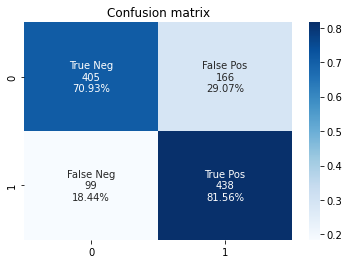

In [ ]:
cf_matrix = confusion_matrix(test_classes, pred_classes)
cf_matrix_norm = confusion_matrix(test_classes, pred_classes, normalize='true')

# From https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix_norm.flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_norm, annot=labels, fmt="", cmap='Blues');
plt.title('Confusion matrix')
plt.savefig('figures/transformer_2_confusion.png', dpi=300);

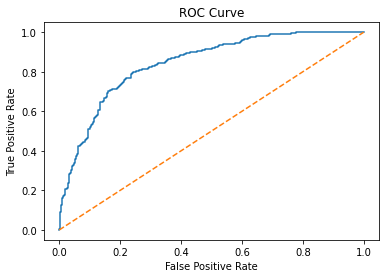

In [ ]:
fpr, tpr, _ = roc_curve(test_classes,  [p for p in preds])

plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1], [0,1], linestyle='dashed')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.savefig('figures/transformer_2_roc_curve.png', dpi=300)